# Practical session n°5

Notions:
- Semantic segmentation
- Intersection over Union
- Image Denoising
- Fully convolutional networks, U-Net
- Weak supervision (in part II): The noise-to-noise and the Neural Eggs Separation scenarios.

Duration: 1 h 30 + 2 h

In P3, we illustrated how Convolutional Neural Networks (CNNs) are trained for image classification tasks. In this practical session, we demonstrate how to achieve pixel-level predictions for tasks like semantic segmentation and image denoising.

To start, we’ll simply apply an off-the-shelf model. Then, we’ll focus on training a model from scratch (part I, exercise 2 and part II).

In P3, we also introduced a crucial set of methods known as "transfer learning," which is particularly effective when there’s limited training data. In this session, we’ll explore another equally important set of methods called "weak supervision," which is well-suited for cases where ground truth is imperfectly known (Part II).

## Part II: denoising with FCN - weakly-supervised approaches




In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.optim as optim
from PIL import Image

In [20]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("You are on GPU !")
else:
  print('Change the runtime to GPU or continue with CPU, but this should slow down your trainings')
  device = torch.device("cpu")

You are on GPU !


First, import the functions contained in the "utile" module.

In [21]:
! git clone https://github.com/nanopiero/ML_S5_etudiants
! cp ML_S5_etudiants/practicals/P5/utile.py .
from utile import gen_noise2noise, voir_batch2D, UNet

fatal: destination path 'ML_S5_etudiants' already exists and is not an empty directory.


###**Exercise 1: The "noise to noise" scenario**

In Exercise 2, Part I, we had pairs (noisy version, clean version) to learn from. However, in real-world applications, clean versions are barely available. \
Sometimes, there are instances where multiple noisy versions are accessible. Consider, for example, photos taken with a telephoto lens with several seconds between shots: the effects of air turbulence on image quality are independent from one image to another. \
In the "noise to noise" scenario [(Lehtinen,2018)](https://arxiv.org/pdf/1803.04189.pdf), we have pairs of noisy images, organized into two sets $B^1_{noisy}$ and $B^2_{noisy}$.
To situate ourselves in this scenario, we utilize the synthetic images from Exercise 1. The *gen_noise2noise* function allows us to sample from both datasets:

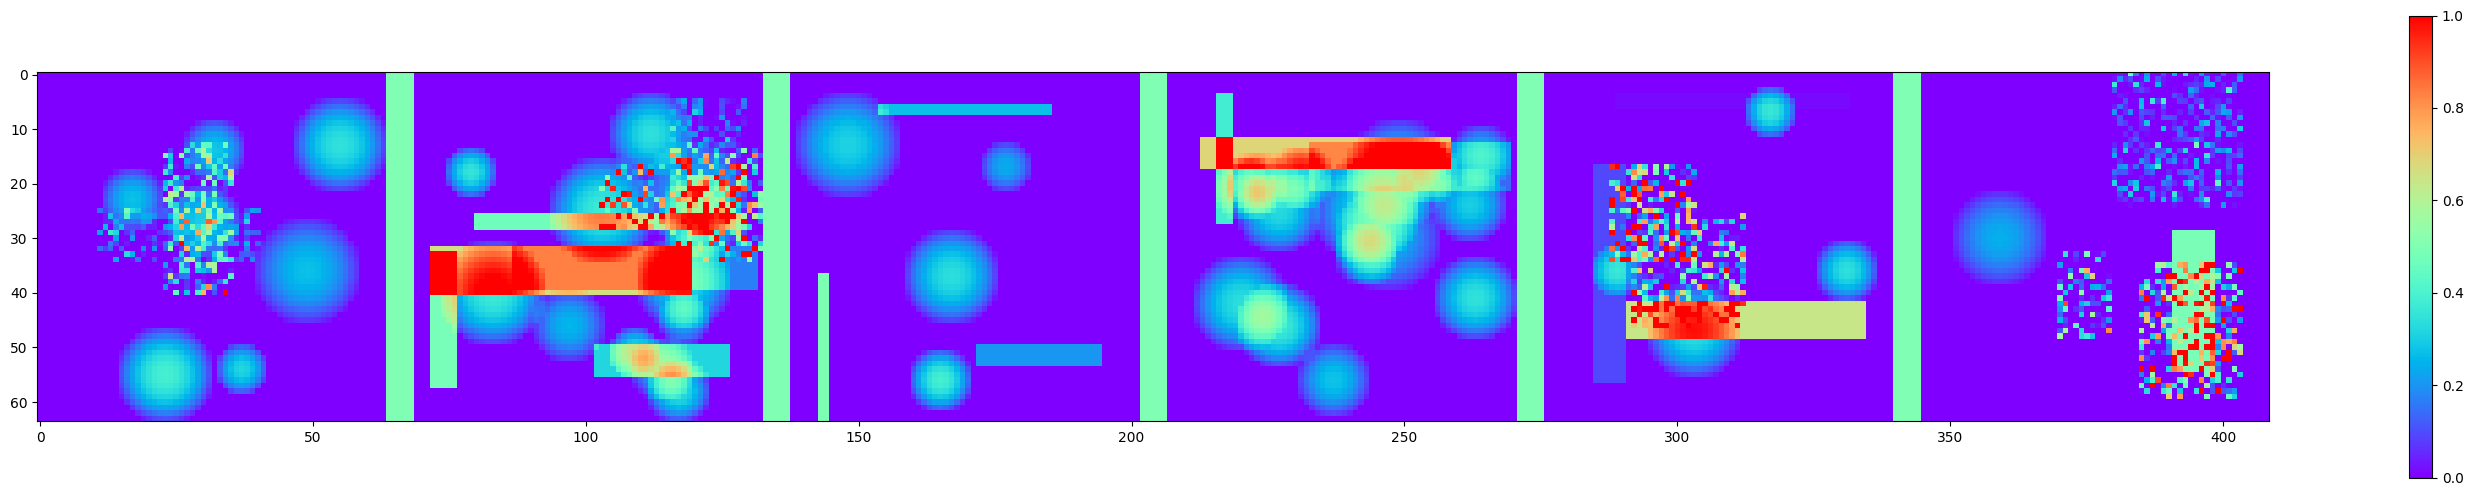

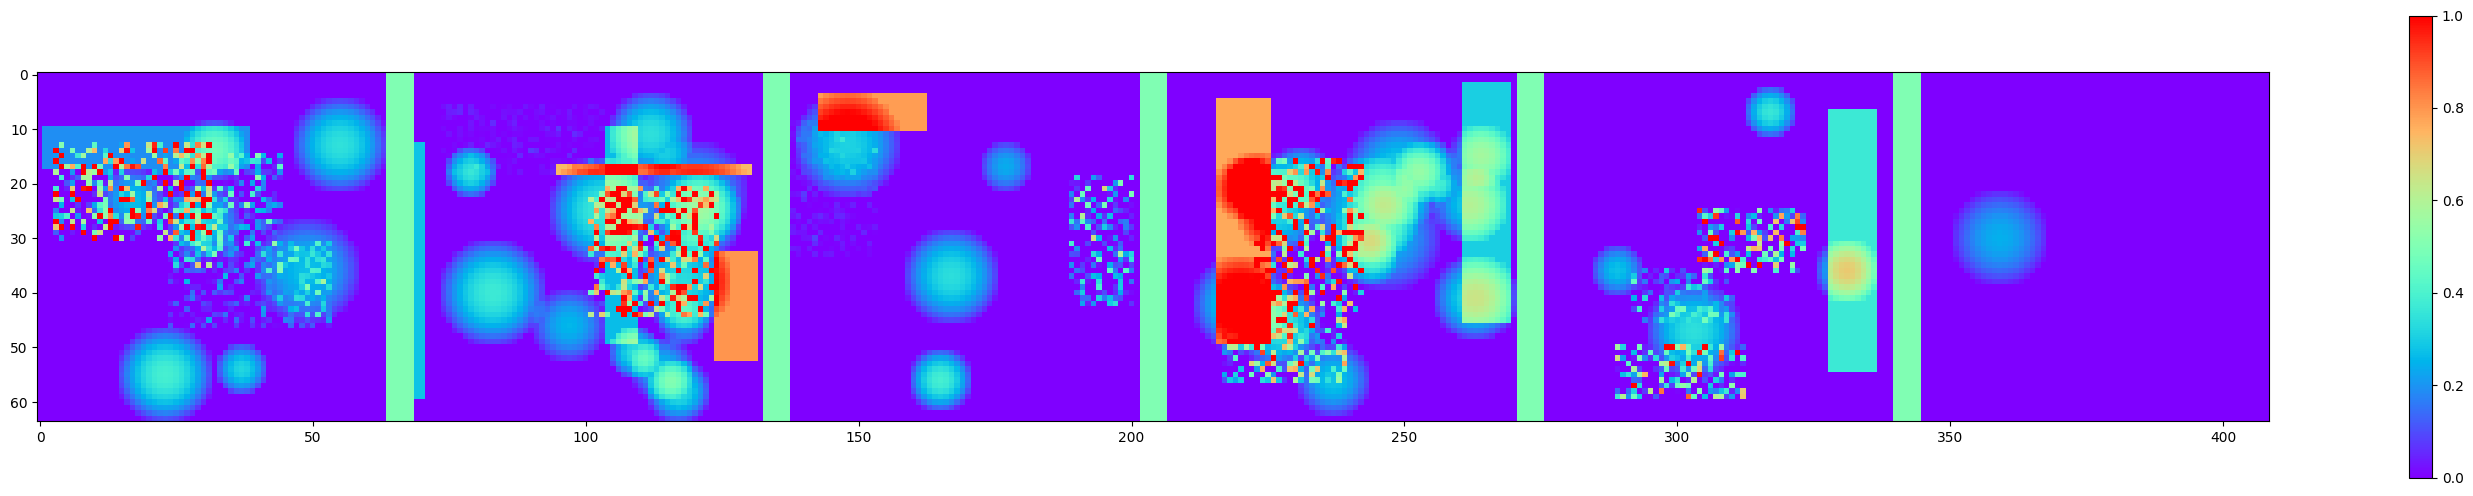

In [22]:
image1, image2 = gen_noise2noise(6)
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(image2.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1)

**Q1:** Define a learning procedure that effectively denoises the image.

In [23]:
fcn = UNet(1,1,16).cuda()

import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [24]:
nepochs = 40
nbatches = 100
batchsize = 64


# BEGIN
loss = nn.L1Loss()

def criterion(output, target):
    return loss(output, target)

train_losses = []  # List to store training losses

fcn = fcn.to(device)

for epoch in range(nepochs):
    print(f"Epoch {epoch + 1}/{nepochs}")

    epoch_losses = []  # List to store losses for each batch in the epoch

    for i in range(nbatches):
        # Load inputs
        inputs, targets = gen_noise2noise(batchsize)

        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = fcn(inputs)
        loss_value = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        epoch_losses.append(loss_value.item())


    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print(f'Epoch loss: {epoch_loss:.4f}')
# END

Epoch 1/40
Epoch loss: 0.1052
Epoch 2/40
Epoch loss: 0.0877
Epoch 3/40
Epoch loss: 0.0858
Epoch 4/40
Epoch loss: 0.0837
Epoch 5/40
Epoch loss: 0.0831
Epoch 6/40
Epoch loss: 0.0830
Epoch 7/40
Epoch loss: 0.0805
Epoch 8/40
Epoch loss: 0.0818
Epoch 9/40
Epoch loss: 0.0797
Epoch 10/40
Epoch loss: 0.0789
Epoch 11/40
Epoch loss: 0.0800
Epoch 12/40
Epoch loss: 0.0808
Epoch 13/40
Epoch loss: 0.0799
Epoch 14/40
Epoch loss: 0.0800
Epoch 15/40
Epoch loss: 0.0801
Epoch 16/40
Epoch loss: 0.0805
Epoch 17/40
Epoch loss: 0.0796
Epoch 18/40
Epoch loss: 0.0794
Epoch 19/40
Epoch loss: 0.0809
Epoch 20/40
Epoch loss: 0.0786
Epoch 21/40
Epoch loss: 0.0791
Epoch 22/40
Epoch loss: 0.0781
Epoch 23/40
Epoch loss: 0.0794
Epoch 24/40
Epoch loss: 0.0791
Epoch 25/40
Epoch loss: 0.0801
Epoch 26/40
Epoch loss: 0.0790
Epoch 27/40
Epoch loss: 0.0787
Epoch 28/40
Epoch loss: 0.0776
Epoch 29/40
Epoch loss: 0.0782
Epoch 30/40
Epoch loss: 0.0779
Epoch 31/40
Epoch loss: 0.0791
Epoch 32/40
Epoch loss: 0.0784
Epoch 33/40
Epoch

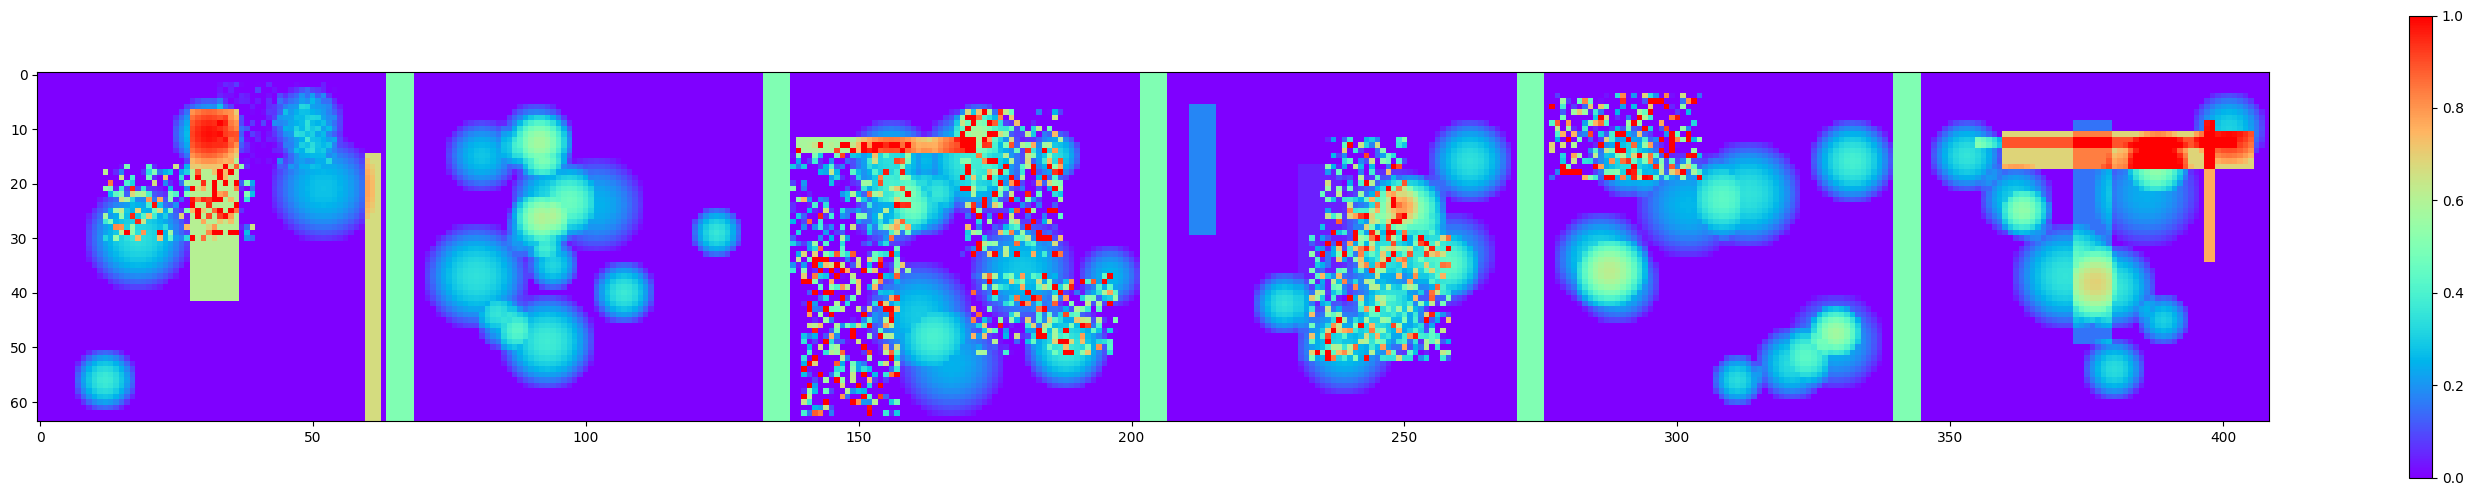

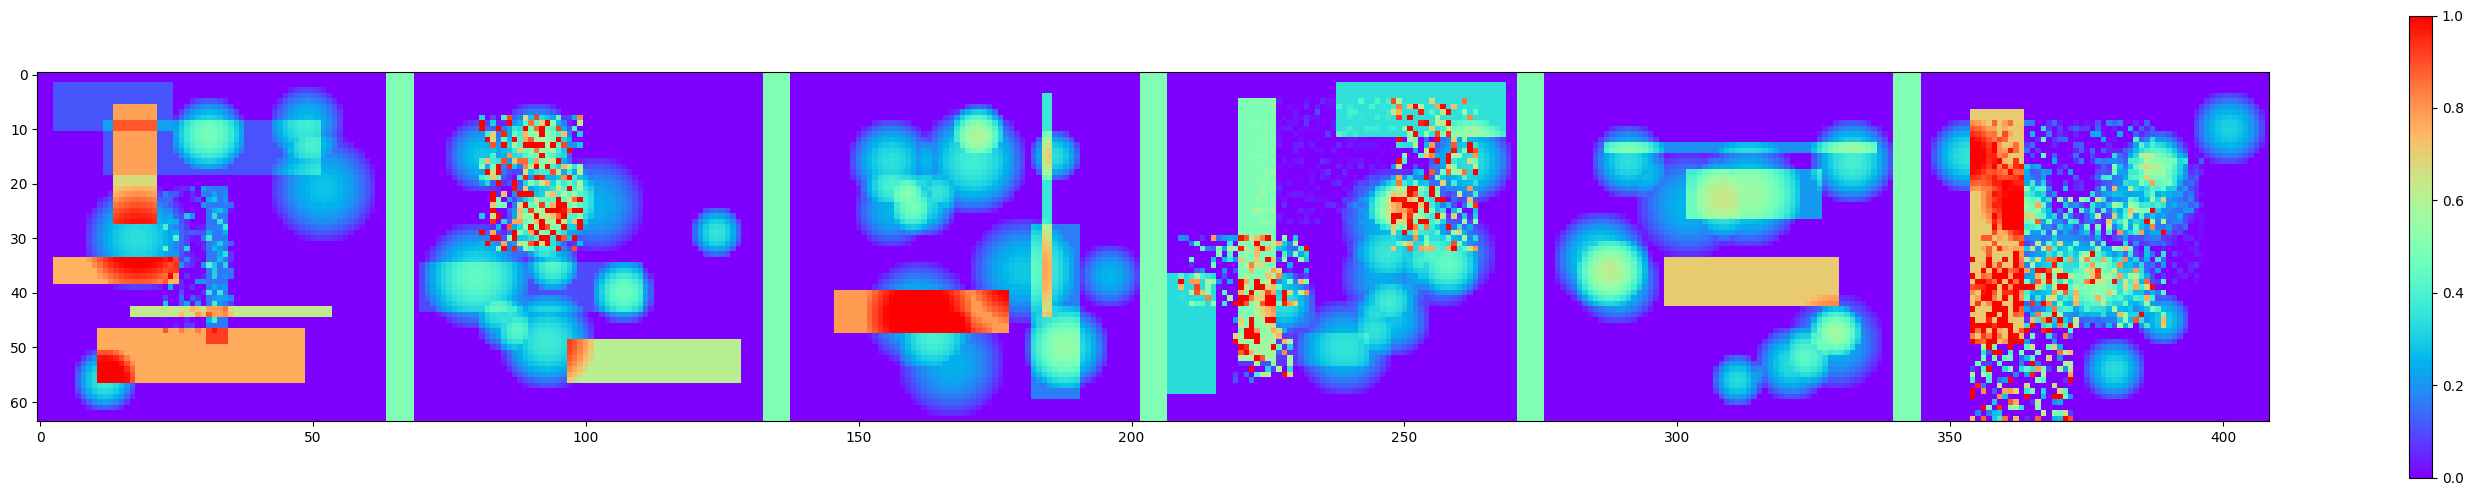

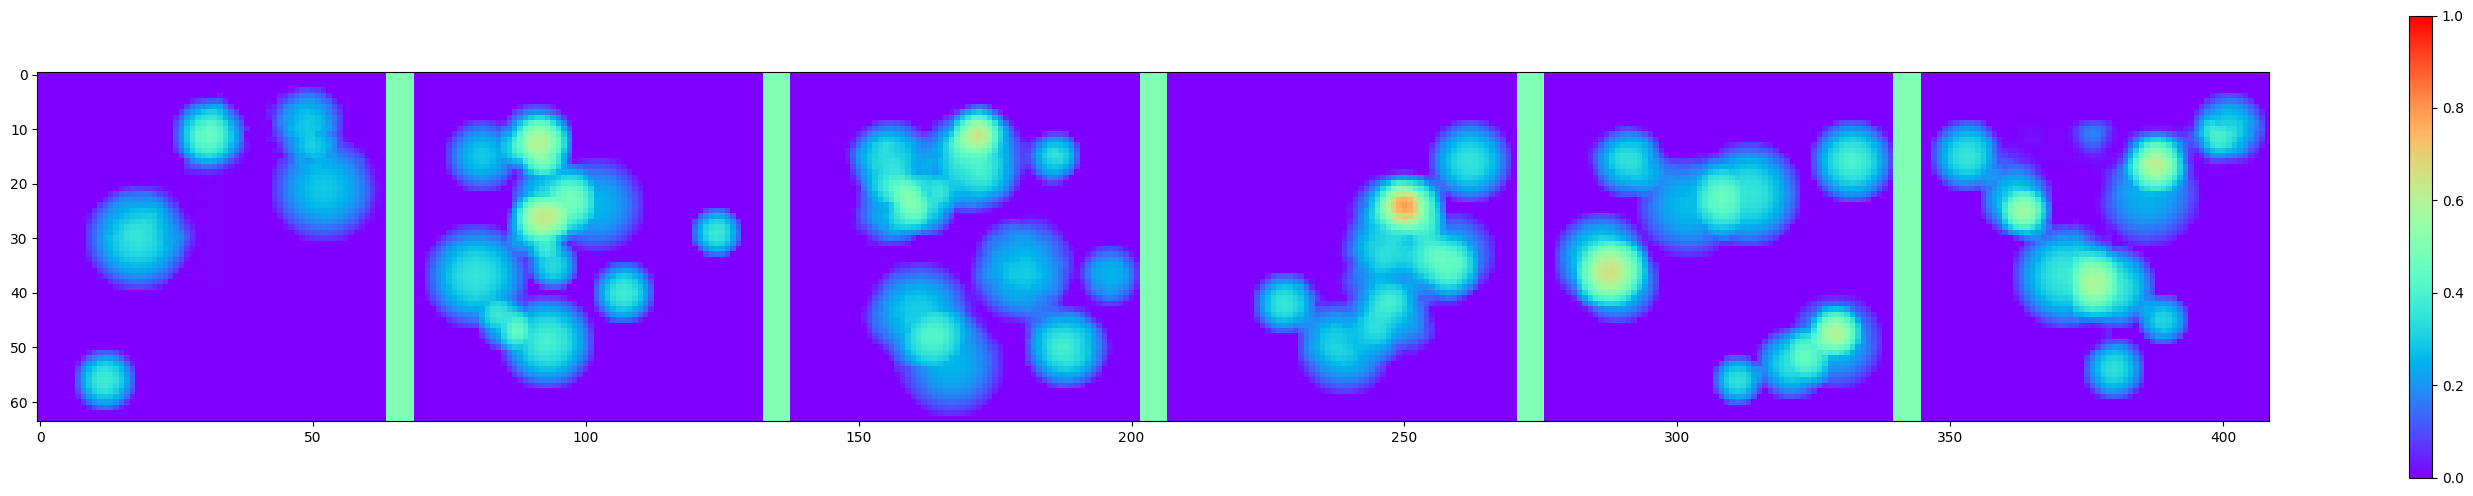

In [25]:
# viz:
fcn.eval()

input, target = gen_noise2noise(6)

output = fcn(input.cuda())

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)  # inputs
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=0,max_scale=1)  # targets
fig3 = plt.figure(2, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1) # outputs


**Q2:** Theoretical analysis:

The training procedure involves searching for the weights $\theta^*$ that satisfy:

\begin{equation}
\theta^* = \underset{\theta}{argmin} {\big \{} \mathbb{E}_{(X,Y)}[ \ \mathcal{L} (f_\theta(X), Y) \ ] {\big \}} \tag{1}
\end{equation}

Rewrite $\mathbb{E}_{(X,Y)}[ \mathcal{L} (f_\theta(X), Y) ]$ to justify the approach taken for **Q1**.



...


###**Exercise 2: The "NES" scenario (Neural Egg Separation)**

In another scenario, two sources of images can be sampled independently. The first provides noisy images containing the object of interest. Images from the second source contain only noise. Additionally, the corruption process, i.e., how the noise is combined with the clean image, is assumed to be known. This is a relatively common scenario. For instance, in the case of meteorological radar images, it is possible to extract images containing only noise during non-precipitation periods.

This scenario was defined by [Halperin et al (2018)](https://arxiv.org/pdf/1811.12739.pdf). These authors propose an iterative method to address it (Neural Egg Separation). In this exercise, we will rely on a fairly similar principle, still using our synthetic images.

The functions gen1_NES and gen2_NES allow sampling from the two sources. The corruption process is trivial: the noise (rectangles) is simply added to the clean image (cells).   



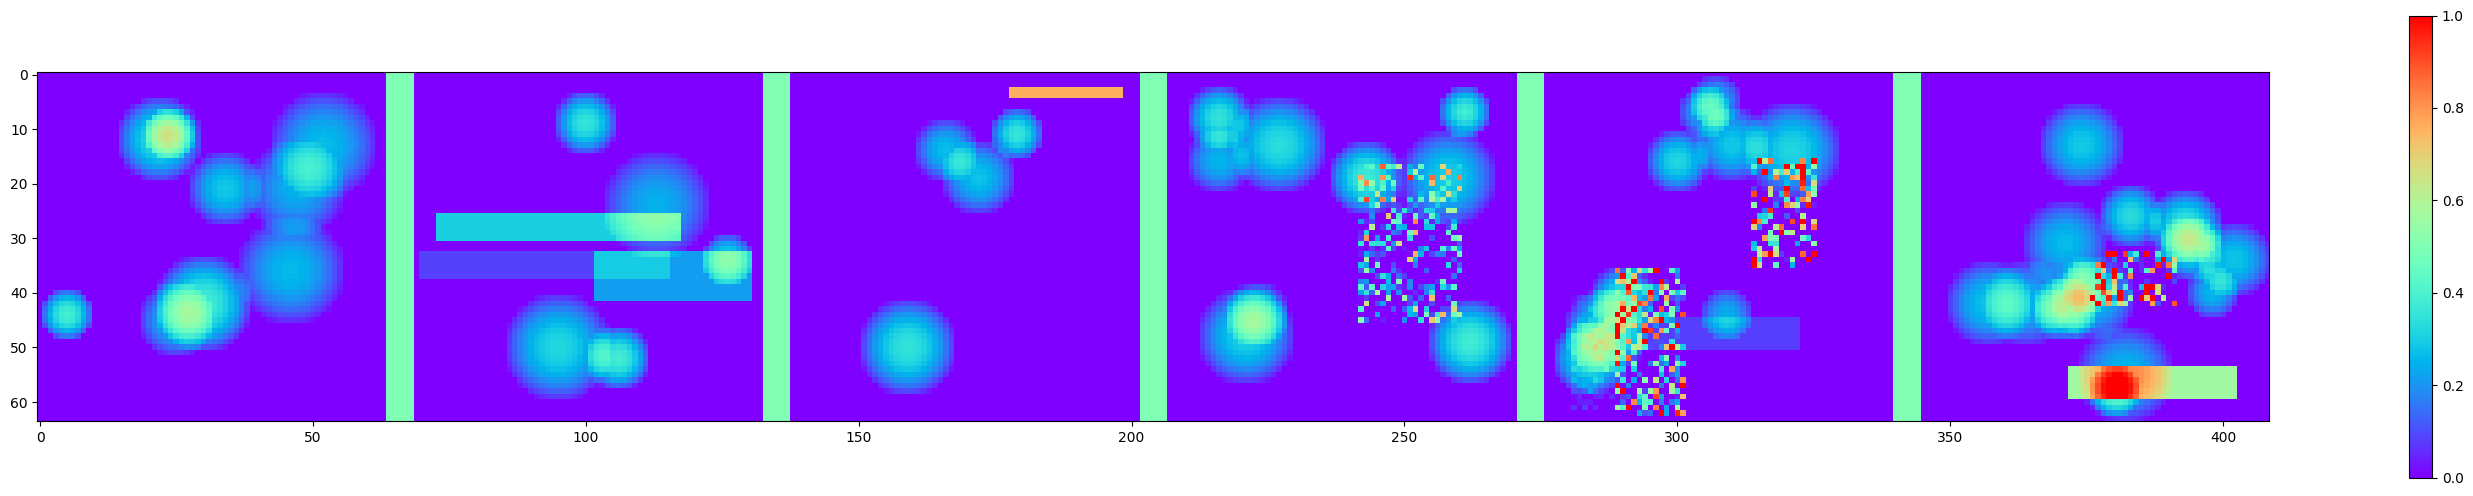

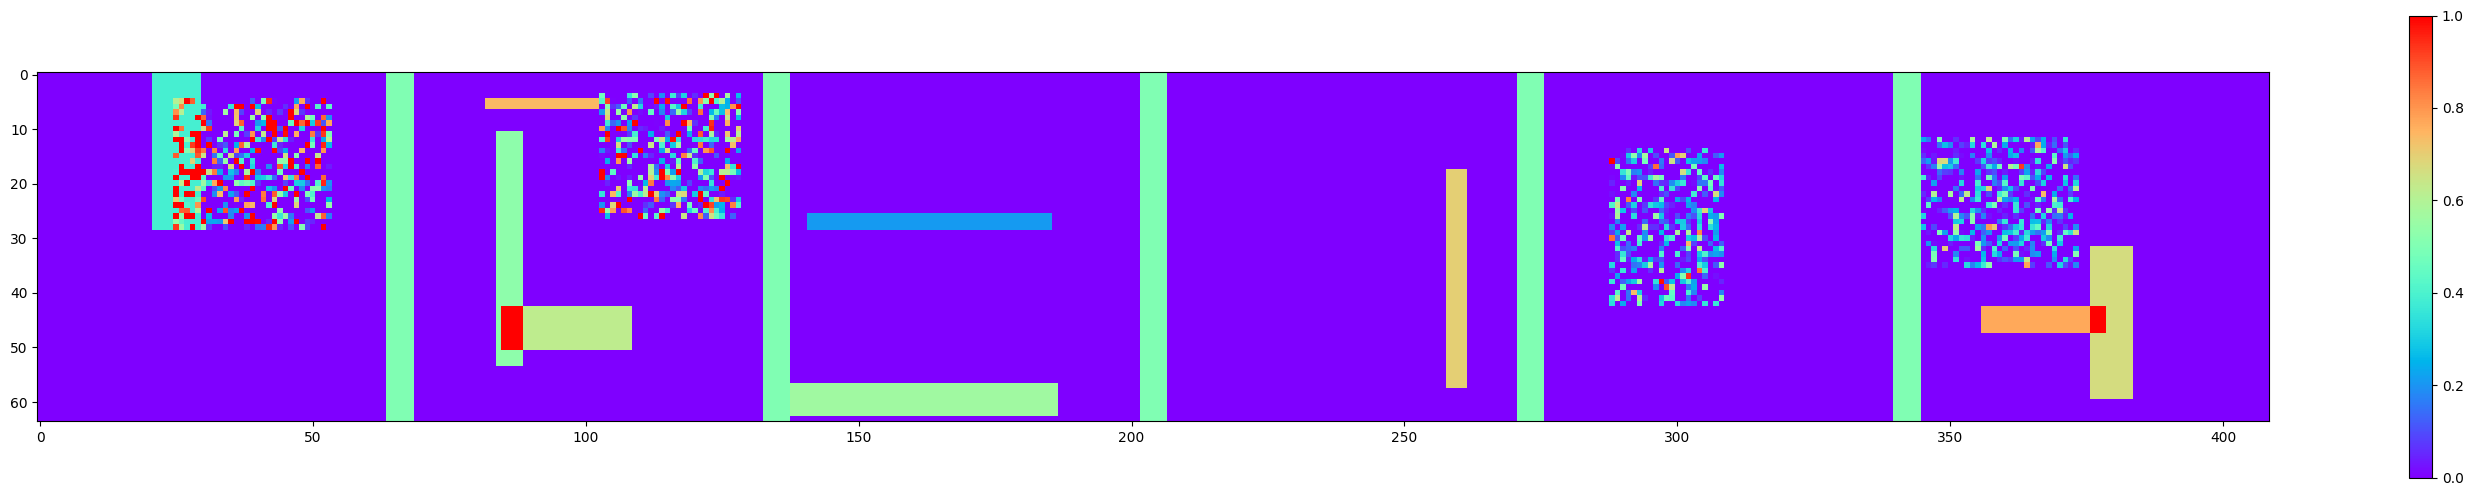

In [26]:
from utile import gen1_NES, gen2_NES

image1 = gen1_NES(6)
noise = gen2_NES(6)

# sample noisy pictures:
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

# sample noise:
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(noise, 6, fig2, k=0, min_scale=0,max_scale=1)

**Q1:** Propose a learning strategy that leads to effective denoising.

**Q2:** Discuss the limitations of the method and mention some avenues for improvement.